# 01 – Exploração do Snapshot

Primeiro notebook do **creditlab**.

Nele, vamos:
1. Instanciar o `CreditDataSynthesizer`.
2. Gerar a *safra 0* (snapshot) para alguns grupos homogêneos.
3. Fazer uma exploração inicial: contagem de contratos por grupo, estatísticas descritivas e um histograma de dias em atraso.

⚠️ Este notebook assume que o módulo `credit_data_synthesizer.py` está no mesmo diretório ou em `PYTHONPATH`.

In [ ]:
import sys
from pathlib import Path

# Adiciona o diretório-pai ao sys.path
sys.path.append(str(Path().resolve().parent))

import pandas as pd
import matplotlib.pyplot as plt


from importlib import reload
import credit_data_synthesizer as cds
reload(cds)  # garante versão atual no notebook

from credit_data_synthesizer import (
    CreditDataSynthesizer,
    default_group_profiles,   # função helper já incluída no módulo
)

from credit_data_sampler import (
    TargetSampler
)

pd.set_option('display.max_rows', 500)

## Parâmetros iniciais

In [ ]:
# from credit_data_synthesizer import CreditDataSynthesizer, default_group_profiles
# from credit_data_sampler import TargetSampler

# # gerar painel com churn dinamico
# synth = CreditDataSynthesizer(
#     group_profiles=default_group_profiles(2),
#     contracts_per_group=1_000,
#     n_safras=12,
#     new_contract_rate=0.05,
#     closure_rate=0.03,
# )
# _, panel, _ = synth.generate()

# # rebalancear bad-rate preservando ranking dos grupos
# sampler = TargetSampler(target_ratio=0.08, preserve_rank=True)
# panel_bal = sampler.fit_transform(panel, target_col="ever90m12", safra_col="safra")
# display(panel_bal.head())

In [ ]:
#panel_bal.groupby('grupo_homogeneo')['ever90m12'].mean()*100

In [ ]:
# ----- parâmetros que você quer -----
YEARS=3
n_groups = 5
contracts_per_group = 500
n_safras = 12*YEARS
seed = 0

# 1) Obtenha os perfis padrão e pegue só os três primeiros
group_profiles = default_group_profiles(n_groups)

# 2) Instancie o sintetizador
synth = CreditDataSynthesizer(
    group_profiles=group_profiles,
    contracts_per_group=contracts_per_group,
    n_safras=n_safras,
    random_seed=0,
    start_safra = 201501,
    target_ratio=0.10,
    new_contract_rate=0.045,
    closure_rate=0.025,
    force_event_rate=False,
    verbose=True
)

## Geração da safra 0

In [5]:
# 3) Gere os dados
df_snapshot, df_panel, df_trace = synth.generate()

print(f"Snapshot gerado com {len(df_snapshot):,} linhas")
print(f"Painel gerado com {len(df_panel):,} linhas")
print(f"Rastro gerado com {len(df_trace):,} linhas")
display(df_snapshot.head())

unmet groups: {('201601', 'GH1'): 2289, ('201601', 'GH2'): 2134, ('201601', 'GH4'): 1659, ('201601', 'GH3'): 1798, ('201601', 'GH5'): 1705, ('201601', 'GH6'): 1354, ('201509', 'GH1'): 2505, ('201509', 'GH2'): 2387, ('201509', 'GH3'): 2349, ('201509', 'GH6'): 2520, ('201509', 'GH5'): 2049, ('201509', 'GH4'): 1824, ('201507', 'GH1'): 79, ('201507', 'GH3'): 54, ('201507', 'GH6'): 2690, ('201507', 'GH2'): 2191, ('201507', 'GH4'): 2192, ('201507', 'GH5'): 1954, ('201510', 'GH3'): 2815, ('201510', 'GH1'): 2400, ('201510', 'GH2'): 2115, ('201510', 'GH5'): 2178, ('201510', 'GH6'): 1967, ('201510', 'GH4'): 1748, ('201606', 'GH2'): 1390, ('201606', 'GH3'): 1194, ('201606', 'GH1'): 839, ('201606', 'GH6'): 836, ('201606', 'GH5'): 844, ('201606', 'GH4'): 602, ('201508', 'GH3'): 2875, ('201508', 'GH1'): 3054, ('201508', 'GH2'): 2554, ('201508', 'GH4'): 2101, ('201508', 'GH5'): 2329, ('201508', 'GH6'): 2153, ('201607', 'GH3'): 1360, ('201607', 'GH1'): 896, ('201607', 'GH6'): 797, ('201607', 'GH5'): 7

Snapshot gerado com 38,760 linhas
Painel gerado com 830,920 linhas
Rastro gerado com 3,227 linhas


,id_contrato,grupo_homogeneo,data_inicio_contrato,data_ref,safra,dias_atraso,nivel_refinanciamento,renda_mensal,tempo_no_endereco_anual,tempo_no_emprego_anual,...,ever360m18,flag_cura,write_off,id_cliente,data_nascimento,sexo,duration_m,age_months,data_fim_contrato,subcluster
0,9.999998e+06,GH1,2014-07-05,2015-01-01,201501,15,0,3432.210895,1.797669,1.594742,...,0,0,0,574.188154,1990-12-13,F,27.228062,-0.009348,NaT,3.989564
1,9.999999e+06,GH1,2014-09-14,2015-01-01,201501,120,0,3685.213710,1.793612,12.737377,...,0,0,0,985.662333,1958-12-08,M,28.205492,-0.000088,NaT,6.022622
2,9.999999e+06,GH1,2014-09-14,2015-01-01,201501,120,0,3686.885089,1.962924,12.679814,...,0,0,0,959.828465,1958-12-08,M,28.199071,-0.000038,NaT,6.073887
3,9.999999e+06,GH1,2014-09-14,2015-01-01,201501,120,0,3708.325325,1.828912,12.674561,...,0,0,0,1018.494812,1958-12-08,M,28.423381,-0.000188,NaT,6.147828
4,9.999999e+06,GH1,2014-07-05,2015-01-01,201501,15,0,3399.465139,1.804773,1.537889,...,0,0,0,592.008743,1990-12-13,F,27.772374,-0.009343,NaT,4.024792


In [ ]:
df_panel['safra'].min()#,df_panel['safra'].max()

In [ ]:
df_panel.groupby(['safra','grupo_homogeneo'])['ever90m12'].mean()*100

In [ ]:
df_panel[df_panel['safra'].astype(int)>=201601].groupby('grupo_homogeneo')['ever90m12'].mean()*100

In [ ]:
df_panel['nivel_refinanciamento'].describe()

In [ ]:
df_snapshot['dias_atraso'].value_counts()

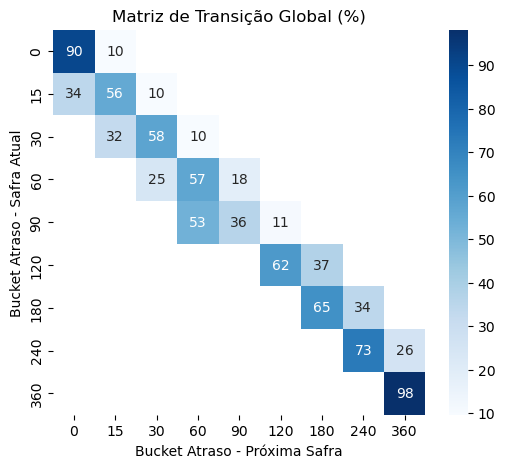

In [12]:
import numpy as np
import importlib
import transition_matrix_estimator

importlib.reload(transition_matrix_estimator)

from transition_matrix_estimator import TransitionMatrixLearner

global_learner = TransitionMatrixLearner(buckets=[0,15,30,60,90,120,180,240,360])
global_learner.fit(
    df_panel,
    id_col="id_contrato",
    time_col="data_ref",
    bucket_col="dias_atraso",
    group_col='grupo_homogeneo',
)

global_learner.plot_heatmaps(modes=["global"]); #save_dir="figs/")

In [ ]:
import numpy as np
import importlib
import ever_cure_matrix
importlib.reload(ever_cure_matrix)
from ever_cure_matrix import EverCureMatrixLearner

ecm = EverCureMatrixLearner(buckets=[0, 15, 30, 60, 90])

ecm.fit(
    df_panel,
    horizon=12,
    id_col="id_contrato",
    time_col="data_ref",
    bucket_col="dias_atraso",
    )

ecm.plot_heatmaps()

plt.show()

In [ ]:
# balanceando target
sampler = TargetSampler(target_ratio=0.10)
balanced = sampler.fit_transform(df_panel, target_col="ever90m12")

#prev = balanced.groupby("safra")["ever90m12"].mean()*100
#print("Prev per safra (balanced):")
#print(prev.head())

In [ ]:
df_snapshot.groupby('sexo')['ever90m12'].mean()*100

In [ ]:
df_snapshot.groupby('grupo_homogeneo')['ever90m12'].mean()*100

In [ ]:
balanced.groupby('grupo_homogeneo')['ever90m12'].mean()*100

In [ ]:
len(balanced), len(df_panel)

In [ ]:
balanced['safra'].value_counts()

In [ ]:
balanced.groupby(by='safra', as_index=True)['ever90m12'].mean()*100

### Contagem de contratos por `grupo_homogeneo`

In [ ]:
df_snapshot['grupo_homogeneo'].value_counts()

### Estatísticas descritivas das variáveis numéricas

In [ ]:
cols_numericas = balanced.select_dtypes(include='number').columns.drop(['id_contrato', 'id_cliente'])

agg_df = (
    balanced[cols_numericas.tolist() + ['grupo_homogeneo']]
    .groupby('grupo_homogeneo')
    .agg(['min', 'mean', 'max'])
)

# Flatten columns
agg_df.columns = ['_'.join(col) for col in agg_df.columns]
agg_df.reset_index(inplace=True)

# Supondo que agg_df tenha a coluna 'grupo_homogeneo'
agg_df = agg_df.copy()
agg_df['grupo_idx'] = agg_df['grupo_homogeneo'].str.extract(r'GH(\d+)').astype(int)
agg_df = agg_df.sort_values('grupo_idx').drop(columns='grupo_idx')

agg_df.head(10)

### Distribuição de `dias_atraso`

In [ ]:
plt.figure()
balanced['dias_atraso'].hist(bins=30)
plt.xlabel('Dias em atraso')
plt.ylabel('Número de contratos')
plt.title('Histograma de dias em atraso – safra 0')
plt.show()

In [ ]:
df_snapshot.shape